# Intro and setup

![London travel planning](img/01_london-travel-planning.jpg)

**Travelling is one of my favourite hobbies but it often comes with frustration.**

It can be so difficult to plan a trip.  There are so many things to do in the travel planning process, e.g.:
* Choose a destination (probably from a shortlist).
* Book flights.
* Book accommodation (again from a shortlist).
* Develop a travel itinerary.
* Pack bags for the trip.
* Arrange transport (e.g. to airport and accommodation).

All that is done before even going on a trip, but already the number of tasks involved seems time-consuming.  Some trips can take days to plan over a long period and the planning process is typically iterative (e.g. develop a draft itinerary and then refine it nearer the time).

**Even as a seasoned traveller I would say that developing a travel itinerary is the hardest thing to do in that list.**  An itinerary defines a trip and it is something that you want to get right, especially if it may be your only visit to a destination.  For all the travel guides and websites I examine when planning a trip, I normally need to adjust my plans 'on the day': e.g. the transportation isn't as straightforward as I thought; an attraction is closed; plans are dependent on weather conditions.

**Since itineraries are so time-consuming to get right, before and during a trip, I've sought a way to make it easier for me to develop a travel itinerary via data science techniques.**  As someone who has lived, studied and worked in London, I thought it would be worthwhile to start off the project by using data on London.

I read Hamza Bendemra's post on [geo-location clustering in Paris](https://towardsdatascience.com/using-unsupervised-learning-to-plan-a-paris-vacation-geo-location-clustering-d0337b4210de), which inspired me to do a take on a project like this one.  With my experience in travel technology, experience of travel planning for large groups and a project on transportation, I thought I could go much further in my own project on travel planning.

**These are the two aims of this notebook:**
* _Find the nearest rail station for London's top attractions_ and calculate how close the attractions are to each station.
* _Group together London's top attractions and use the groupings for itinerary planning_ (e.g. spend one day for attractions in one group, another day for attractions in a second group, etc.).

That could help to establish a proof of concept for a more ambitious project.

## Packages and magic (from environment)

In [1]:
# Built-in libraries
import os
import os.path
from math import radians, sin, cos, asin, sqrt, floor, ceil

# Core libraries
from dotenv import find_dotenv
import numpy as np
import pandas as pd
import scipy as sp

# Additional libraries
import hdbscan

# Plotting & images
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import gmaps
from IPython.core.display import Image

## Other packages and settings (from project directory)

Load settings from the project directory and other packages.

In [2]:
file_dir = os.getcwd()
project_dir = os.path.dirname(find_dotenv())  # env file in project directory

# Load up project directory...
os.chdir(project_dir)
# ...then load settings and gather other packages
%run settings.py
from src.data import pandas_helpers

# Change directory back to this notebook's directory
os.chdir(file_dir)

## Notebook settings and check on packages loaded

In [3]:
# Set aesthetic parameters for this notebook
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

`gmaps` package will be used in this notebook to produce maps.  To avoid issues with requests being denied, use an API key.

In [4]:
gmaps_key = os.environ.get('GOOGLE_MAPS_API_KEY')
assert gmaps_key is not None

In [5]:
gmaps.configure(api_key=gmaps_key)

# Load data

There are two datasets to load in order to do analysis:
* **`rail`:** a spreadsheet with geodata about over 600 rail stations in London.
* **`sights`:** a spreadsheet with data from the top London attractions listed on TripAdvisor.

This data collection did not involve any web scraping!

The `sights` dataset only required a little time for data entry.  The `rail` dataset that I've developed has been used in my project on the London rail network.

There are only a few features in each dataset so they will be explained in more detail below.

## Rail dataset

Each record of this dataset contains information about a rail station in London.  The features include a variety of geodata, e.g.: latitude; longitude; postcode; TfL Rail Zone.

In [6]:
rail = pd.read_excel('../data/interim/rail_london.xlsx', sheet_name='stations',
                     index_col='id')
rail.head()

,urn,station,latitude,longitude,zone,postcode,id_constructor_preid,id_constructor_prime,id_constructor_group,id_constructor_pref,comment,open
id,,,,,,,,,,,,
01001,49,Blackfriars,51.511587,-0.102995,1,EC4V 4DD,1,2,0,010,NaN,True
01002,87,Cannon Street,51.511362,-0.090251,1,EC4N 6AP,2,3,0,010,NaN,True
01003,102,Charing Cross,51.508359,-0.124803,1,WC2N 5HS,3,5,0,010,NaN,True
01004,190,Euston,51.528664,-0.133296,1,NW1 2DU,4,7,0,010,NaN,True
01005,198,Fenchurch Street,51.511567,-0.078554,1,EC3M 4AJ,5,11,0,010,NaN,True


Not all of the columns in the dataset are needed for the analysis (e.g. some of them are used in Excel to group data), so they will be removed.

In [7]:
# Remove unnecessary cols
rail.drop(columns=['id_constructor_preid', 'id_constructor_prime',
                   'id_constructor_group', 'id_constructor_pref'],
          inplace=True)

In [8]:
rail.dtypes

urn            int64
station       object
latitude     float64
longitude    float64
zone          object
postcode      object
comment       object
open            bool
dtype: object

In [9]:
rail.shape

(616, 8)

## Sights dataset

There are 21 sights in the dataset.  I examined the top 45 'attractions' in London but did not include types of attractions as they are not fixed locations.  For example, 'Game & Entertainment Centres' is ranked 44th for things to do in London, so that is not in the dataset.

![TripAdvisor top attractions in London](img/01_top-london-attractions.jpg)

In [10]:
sights = pd.read_excel('../data/interim/tripadvisor_london.xlsx', index_col='rank')
sights.head()

,attraction,latitude,longitude,duration_hr_min,duration_hr_max,duration_minute_min,duration_minute_max
rank,,,,,,,
1,National Gallery,51.508929,-0.128299,2.0,3.0,120.0,180.0
2,Churchill War Rooms,51.502159,-0.129357,NaN,NaN,NaN,NaN
3,The British Museum,51.519413,-0.126957,2.0,3.0,120.0,180.0
4,St. James's Park,51.501667,-0.131944,1.0,2.0,60.0,120.0
5,V&A - Victoria and Albert Museum,51.496639,-0.172180,2.0,3.0,120.0,180.0


TripAdvisor lists the recommended time to visit for some attractions in an interval format: e.g. 2–3 hours or 1–2 hours.  I have used the columns `duration_hr_min` and `duration_hr_max` to represent the lower and upper bounds (in hours).

In [11]:
# Filter out missing lat-long data:
sights.dropna(subset=['latitude', 'longitude'], how='any', inplace=True)

In [12]:
sights.dtypes

attraction              object
latitude               float64
longitude              float64
duration_hr_min        float64
duration_hr_max        float64
duration_minute_min    float64
duration_minute_max    float64
dtype: object

In [13]:
sights.shape

(21, 7)

# Nearest station to attractions

**First aim of the project:** Find the nearest rail station for London's top attractions and calculate how close the attractions are to each station.

In essence, the primary problem is a 'nearest neighbours' problem and the secondary problem involves applied trigonometry.

The rationale for tackling this aim first is to get more context on the attractions before approaching the travel planning problem, which is an unsupervised learning problem.

## Setup

There are 21 attractions that need a 'nearest station' calculated from over 600 stations.

In order to work out the nearest neighbour efficiently for the data, a **KD Tree** can be set up for the station geodata.

In [14]:
# Set up KD Tree object
rail_tree = sp.spatial.KDTree(np.array(rail[['latitude',
                                             'longitude']]))

# KD Tree data is in array form
rail_tree.data.shape  # shape (n, 2), where n is number of stations

(616, 2)

The attraction geodata can then be queried on the tree.

In [15]:
# Create array of lat-long pairs for each sight
sight_geo_pairs = np.array(sights[['latitude', 'longitude']])

sight_geo_pairs[:5]  # display first 5

array([[51.508929 , -0.128299 ],
       [51.5021585, -0.1293572],
       [51.5194133, -0.1269566],
       [51.501667 , -0.131944 ],
       [51.4966392, -0.17218  ]])

In [16]:
# Query the nearest neighbours of the tree and store info in arrays
nn_dist, nn_id = rail_tree.query(sight_geo_pairs, p=2)  # Euclidean distance

The tree query returns two arrays:
* `nn_dist`: Euclidean distance between the attraction queried and the nearest station.
* `nn_id`: numerical identifier stored in the tree for the nearest station.

The **Euclidean distance** is the distance 'as the crow flies' between two points.  It is the most practical distance we can use for nearest neighbour calculations, as there is not any street-map data available for this project, which would be of use for obtaining actual walking distances.

In [17]:
nn_dist[:5]  # first 5 Euclidean distances

array([0.00236287, 0.00442041, 0.0043079 , 0.00282407, 0.00310353])

In [18]:
nn_id[:5]  # first 5 identifiers (numerical order of station in tree data)

array([387, 408, 398, 402, 400])

## Nearest neighbour calculations

With the arrays returned by the query, it is not much work now to obtain the name of the nearest station for each attraction.

The tree identifiers match up to the row numbers of the `rail` dataset, so slicing the series of station names by the `nn_id` array returns the names of the nearest stations.

In [19]:
# Slice station series to return the station names
rail['station'].iloc[nn_id].values[:5]

array(['Leicester Square', 'Westminster', 'Russell Square',
       "St. James's Park", 'South Kensington'], dtype=object)

'387', the first value in `nn_id`, is the numerical position in the tree for the nearest station to London's top attraction.

By accessing that row of the `rail` dataframe, we can see that Leicester Square is the nearest station by Euclidean distance, according to the geodata.

In [20]:
rail.iloc[387]

urn                       316
station      Leicester Square
latitude              51.5113
longitude           -0.128242
zone                        1
postcode             WC2H 0AP
comment                   NaN
open                     True
Name: 71027, dtype: object

Now that we can see the first example in action, it's time to find the nearest stations for all of the attractions in the dataset.

The nearest station to the Churchill War Rooms according to the data is Westminster station, while the nearest station to the Victoria & Albert Museum is South Kensington station.

In [21]:
# Create a new column in sights df for nearest station
sights['nearest_station'] = rail['station'].iloc[nn_id].values

# Display the nearest station for the top 5 attractions
sights[['attraction', 'nearest_station']].head()

,attraction,nearest_station
rank,,
1,National Gallery,Leicester Square
2,Churchill War Rooms,Westminster
3,The British Museum,Russell Square
4,St. James's Park,St. James's Park
5,V&A - Victoria and Albert Museum,South Kensington


**The Euclidean distances so far are not easy to interpret and do not account for the Earth's surface.**

We cannot find out the distance in miles, for example, from the distances already calculated.

**We need to have the lat-long pairs of both points, which form a line, in order to calculate the miles between them (via the haversine formula).**  Therefore we must store all four pieces of information in order to calculate those distances.

The lat-long pairs for nearest neighbour analysis are going to be stored in these arrays:
* `sight_geo_pairs`: lat-long pairs for each attraction
* `station_geo_pairs`: lat-long pairs for each nearest neighbour station

The two together can then be concatenated and passed through a function, which will make it easier to create a feature that stores the distance later on.

In [22]:
station_geo_pairs = rail[['latitude', 'longitude']].iloc[nn_id].values
station_geo_pairs[:5]

array([[51.51129118, -0.12824215],
       [51.50140159, -0.12500208],
       [51.52301304, -0.1245902 ],
       [51.49960979, -0.13387876],
       [51.49407137, -0.17392302]])

## Distance calculations

The **haversine formula** applies trigonometry on a sphere to calculate the distance between two points on a sphere.  It can be used to give an approximate (Euclidean) distance between two points on Earth.

In [23]:
def haversine(lat1, lon1, lat2, lon2, unit='miles'):
    """
    Calculate the haversine distance between two pairs of (lat, long) points.
    Units: 'miles' (default) or 'feet'.
    
    """
    R = 3959.87433  # Earth radius (miles).  Equivalent to 6372.8 km.
    
    # Convert points and distances to radians
    delta_lat = radians(lat2 - lat1)
    delta_lon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    
    a = sin(delta_lat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(delta_lon / 2) ** 2
    c = 2 * asin(sqrt(a))
    
    if unit == 'feet':
        return int(R * c * 5280)  # 1 mile is 5280 ft ; return integer
    else:
        unit = 'miles'  # force 'miles' for any other argument
        return R * c

**Before calculating distances, let's get some more context on the geodata for the nearest stations for the top 5 attractions.**  Notice in the table below that each attraction has a different station as its nearest station.

Note: the function is used here to retrieve geodata from `rail` dataframe, via a lookup of values in `sights['nearest_station']`.

This `index_matcher` function, loaded from my `pandas_helpers` file, is used to assist with doing a lookup of the values of a series in one dataframe against columns in another dataframe (to avoid even clunkier code for filtering and creating dataframes!).

In [24]:
pandas_helpers.index_matcher(sights['nearest_station'], rail,
                             ['latitude', 'longitude', 'postcode'],
                             {'nearest_station': 'station'},
                             concat_matches=True).head()

,nearest_station,latitude,longitude,postcode
rank,,,,
1,Leicester Square,51.511291,-0.128242,WC2H 0AP
2,Westminster,51.501402,-0.125002,SW1A 2JR
3,Russell Square,51.523013,-0.124590,WC1N 1LG
4,St. James's Park,51.499610,-0.133879,SW1H 0BD
5,South Kensington,51.494071,-0.173923,SW7 2NB


Earlier in the notebook there is a note about the need for two pairs of co-ordinates to be collected together in order to calculate the haversine distance.

These co-ordinates will be collected in a Numpy array by concatenating the (lat, long) pairs.

The cell below shows the collected (lat, long) pairs for the top 5 attractions.

In [25]:
np.concatenate([sight_geo_pairs, station_geo_pairs], axis=1)[:5]

array([[51.508929  , -0.128299  , 51.51129118, -0.12824215],
       [51.5021585 , -0.1293572 , 51.50140159, -0.12500208],
       [51.5194133 , -0.1269566 , 51.52301304, -0.1245902 ],
       [51.501667  , -0.131944  , 51.49960979, -0.13387876],
       [51.4966392 , -0.17218   , 51.49407137, -0.17392302]])

With that format, a distance in imperial units can be calculated for each row of the Numpy array.

The elements are unpacked and passed to the haversine function.

In [26]:
# Create a col for the distance
# For each attraction, the two geo pairs are passed to the haversine function to obtain a value
sights['nearest_station_miles'] = [haversine(*four_coords) for four_coords
                                  in np.concatenate([sight_geo_pairs, station_geo_pairs], axis=1)]

As can be seen below, each of the top 5 attractions is approximately 0.2 miles away from its nearest station (as the crow flies).

In [27]:
sights[['attraction', 'nearest_station', 'nearest_station_miles']].head()

,attraction,nearest_station,nearest_station_miles
rank,,,
1,National Gallery,Leicester Square,0.163275
2,Churchill War Rooms,Westminster,0.194532
3,The British Museum,Russell Square,0.268796
4,St. James's Park,St. James's Park,0.164754
5,V&A - Victoria and Albert Museum,South Kensington,0.192667


There are some attractions that are within 500 feet of the nearest station.

For example, The View from the Shard is the attraction with the shortest distance from a station.  It is adjacent to London Bridge station.

In [28]:
sights[['attraction', 'nearest_station', 'nearest_station_miles']]\
    .sort_values('nearest_station_miles').head()

,attraction,nearest_station,nearest_station_miles
rank,,,
17,The View from The Shard,London Bridge,0.029448
21,Big Ben,Westminster,0.049216
14,St. Paul's Cathedral,St. Paul's,0.076196
16,Covent Garden,Covent Garden,0.088292
6,Houses of Parliament,Westminster,0.133093


# Itinerary planning with HDBSCAN

**Second aim of the project:** Group together London's top attractions and use the groupings for itinerary planning (e.g. spend one day for attractions in one group, another day for attractions in a second group, etc.).

Even from the nearest neighbour analysis, it would be clear to people who know their London stations that the top 5 London attractions are not located near each other.  A metropolis like London has its main attractions spread over a wide area, so it would take many days to cover the top 20 attractions listed on TripAdvisor.  Once you have so many attractions in mind, it becomes harder to develop an itinerary, especially if you know little about the destination.

A **density-based clustering algorithm** seems the most appropriate way to cluster the attractions for travel planning.  In ideal terms, we would prefer to have fairly dense clusters, as there would be a greater choice of attractions to include in an itinerary.  We also want to penalise attractions that are relatively far away from the other attractions in the dataset.

I will use the **HDBSCAN algorithm** as its ability to account for density makes it promising for examining geodata.  HDBSCAN is an extension of the DBSCAN algorithm.  I have chosen HDBSCAN because its `min_cluster_size` parameter is intuitive for the clustering we want to do and it can also produce clusters of differing densities.

## Clustering setup

Create `df_plan`, a copy of the `sights` dataframe, for more specific analysis to help with itinerary planning.

In [29]:
df_plan = sights.copy()

The TripAdvisor data on recommended duration for visiting attractions is over an interval period, e.g. 2–3 hours.

Let's create a midpoint `duration_hr_mid`, e.g. 2.5 hours, to represent the average case for each attraction.

In [30]:
df_plan['duration_hr_mid'] = 0.5 * (df_plan['duration_hr_max'] + df_plan['duration_hr_min'])

In [31]:
df_plan['duration_hr_mid'].value_counts(dropna=False)

 2.5    7
 1.5    6
NaN     6
 0.5    1
 3.5    1
Name: duration_hr_mid, dtype: int64

Notice that there are some attractions that do not have a recommended visit duration.  Let's impute values by assigning the average across the attractions to those null values.

In [32]:
df_plan['duration_hr_mid'].fillna(df_plan['duration_hr_mid'].mean(),
                                  inplace=True)

Parameter selection is important for the clustering algorithm and needs to account for the intricacies of the problem.  The algorithm here will do calculations based on haversine distance.

The __`min_cluster_size`__ parameter sets out the minimum number of points required for a cluster.  I choose the value 3 as that is the number of attractions that I think could be covered at a minimum over one day.

The __`min_samples`__ parameter is a bit less intuitive.  Its default value is set to `min_cluster_size`, but if a lower value is chosen then it pulls more of what would have been 'anomalous' points into clusters.  I think a lower value is worthwhile to choose for this problem.  For example, an attraction such as a large park or open space, e.g. Hyde Park, could be surrounded by built-up areas.  One 'point' may not reflect the grand scale of an attraction like Hyde Park, so it seems wrong to penalise cases like that.  However, we probably do not want to select the lowest possible value of 0, as we want to penalise attractions that seem far away from everything else in the dataset where we can.  Therefore I choose the intermediate value of 2 for the analysis.

In [33]:
# Convert geodata to radians
rad_points = np.radians(df_plan[['latitude', 'longitude']].values)

# min_cluster_size = 3: base on desire to visit at least 3 attractions per day
# min_samples: choose intermediate value (higher than 0 but lower than min_cluster_size)
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=2,
                            metric='haversine', prediction_data=True)

# Create a series to store cluster predictions by attraction
cluster_pred = clusterer.fit_predict(rad_points)
df_plan['cluster'] = cluster_pred

## Clusters by attraction

**Let's see the attractions, their predicted clusters and other useful information for itinerary planning all in one table!**

In [34]:
df_plan[['cluster', 'attraction',
         'duration_hr_mid', 'nearest_station']].sort_values('cluster')

,cluster,attraction,duration_hr_mid,nearest_station
rank,,,,
3,-1,The British Museum,2.500000,Russell Square
15,-1,Camden Market,2.033333,Camden Town
17,0,The View from The Shard,1.500000,London Bridge
8,0,Tower Bridge,1.500000,Tower Gateway
9,0,Borough Market,2.033333,London Bridge
10,0,Tower of London,2.500000,Tower Hill
14,0,St. Paul's Cathedral,1.500000,St. Paul's
43,1,Harrods,2.033333,Knightsbridge
5,1,V&A - Victoria and Albert Museum,2.500000,South Kensington


**These are labels I would give to the four clusters that have been formed:**
* 0: City of London and Southwark
* 1: Kensington and Knightsbridge
* 2: The West End
* 3: Westminster and the South Bank

The two attractions in `cluster '-1'` (red), i.e. the _anomalous points_, are the British Museum and Camden Market.  The British Museum is not close enough to the three attractions in cluster 2, which form a fairly tight cluster, for it to be captured there.

**The attractions are shown in a scatterplot below.**

In [35]:
cluster_labels = sorted(df_plan['cluster'].unique())  # cluster labels (sorted)
hex_values = sns.color_palette("Set1").as_hex()  # hex colour

# Map labels to hex colours
color_map = dict(zip(cluster_labels, hex_values))
color_map

{-1: '#e41a1c', 0: '#377eb8', 1: '#4daf4a', 2: '#984ea3', 3: '#ff7f00'}

In [36]:
color_vals = list(df_plan['cluster'].map(color_map).values)

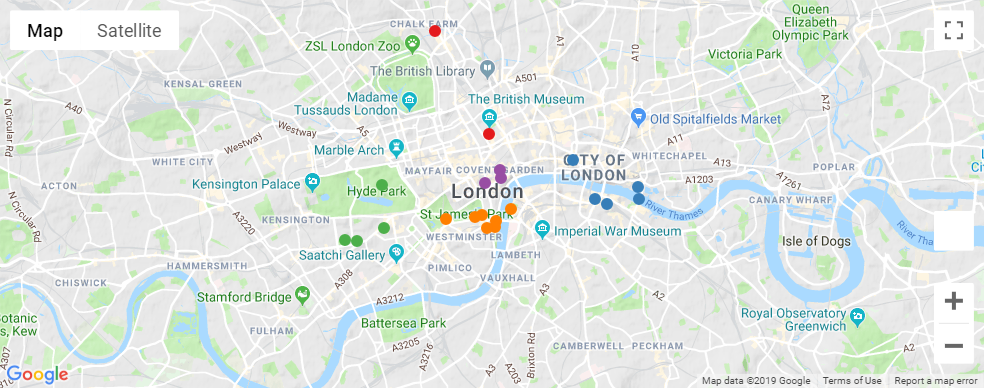

In [37]:
layer = gmaps.symbol_layer(df_plan[['latitude', 'longitude']],
                           fill_color=color_vals, stroke_color=color_vals,
                           scale=4)
fig = gmaps.figure(display_toolbar=True, map_type='TERRAIN')
fig.add_layer(layer)

# fig  # comment out this line if widget cannot display
Image(filename='img/01_london-site-clusters.png')  # downloaded image

## Out-of-sample prediction

One of the highest-rated **travel guides** for London on TripAdvisor is *Chris O's [3 Days In London](https://www.tripadvisor.co.uk/Guide-g186338-k8-London_England.html) guide.*  There are 10 sights listed in the guide so it will be interesting to see if the itinerary's days are grouped in a similar way to the clusters analysed with HDBSCAN.

**This is Chris O's itinerary for the sights in the travel guide:**
* Day 1: The British Museum; Covent Garden; Coca-Cola London Eye
* Day 2: Buckingham Palace; Houses of Parliament; Westminster Abbey
* Day 3: St. Paul's Cathedral; Shakespeare's Globe Theatre; Tower Bridge; Tower of London

It is great to see that there is one sight in the guide that is outside of the `sights` dataset: _Shakespeare's Globe Theatre!_  All the other sights have been clustered with HDBSCAN.

This gives the opportunity to predict the cluster of the **out-of-sample sight** based on the data.

In [38]:
# One test point: Shakespeare's Globe Theatre (51.508076, -0.097194)
oos_pred, oos_conf = hdbscan.approximate_predict(clusterer, np.radians([[51.508076, -0.097194]]))
print(("""Globe Theatre is predicted to be in cluster {} (with {:.4f} confidence)"""
       .format(oos_pred[0], oos_conf[0])))

Globe Theatre is predicted to be in cluster 0 (with 0.9246 confidence)


**The Globe Theatre is predicted to be in cluster 0**, with a high confidence level.

That cluster calculated by HDBSCAN also happens to have Tower Bridge, Tower of London and St. Paul's Cathedral in it!

**Let's examine the itinerary curated by Chris and compare it to the HDBSCAN clusters in more depth.**

In [39]:
# Create dataframe for 'out-of-sample' (OOS) analysis
df_oos = df_plan[['attraction', 'latitude', 'longitude',
                  'duration_hr_mid', 'cluster']].copy()

# Gather the day for each sight in Chris O's travel guide
days = {"The British Museum": 1, "Covent Garden": 1,
        "Coca-Cola London Eye": 1,
        "Buckingham Palace": 2, "Houses of Parliament": 2,
        "Westminster Abbey": 2,
        "St. Paul's Cathedral": 3, "Shakespeare's Globe Theatre": 3,
        "Tower Bridge": 3, "Tower of London": 3}

# Keep only the sights in `days` dict and add the Globe Theatre
df_oos = df_oos[df_oos['attraction'].isin(list(days.keys()))]
df_oos = df_oos.append(pd.Series({'attraction': "Shakespeare's Globe Theatre",
                                  'cluster': 'OOS',
                                  'latitude': 51.508076,
                                  'longitude': -0.097194}, name=122))

# Create new column to represent the day in Chris O's travel guide
df_oos['chris_day'] = df_oos['attraction'].map(days)

# Reindex the dataframe to match the travel guide's order
df_oos = df_oos.reindex([3, 16, 20,
                         19, 6, 11,
                         14, 122, 8, 10])
df_oos

,attraction,latitude,longitude,duration_hr_mid,cluster,chris_day
rank,,,,,,
3,The British Museum,51.519413,-0.126957,2.500000,-1,1
16,Covent Garden,51.511780,-0.123191,2.033333,2,1
20,Coca-Cola London Eye,51.503324,-0.119543,1.500000,3,1
19,Buckingham Palace,51.501364,-0.141890,2.500000,3,2
6,Houses of Parliament,51.499480,-0.124809,2.033333,3,2
11,Westminster Abbey,51.499417,-0.127571,1.500000,3,2
14,St. Paul's Cathedral,51.513845,-0.098351,1.500000,0,3
122,Shakespeare's Globe Theatre,51.508076,-0.097194,NaN,OOS,3
8,Tower Bridge,51.505500,-0.075406,1.500000,0,3


It is interesting that all of the Day 2 sights are in cluster 3 and all of the sights of Day 3 are in cluster 0 (when including the Globe Theatre)!

However Day 1 has each of its three sights in different clusters.

Of the three days, I think that Day 3 is probably the most ambitious in terms of how much time is needed to experience the sights.

**The plot below focuses on cluster 0 and the out-of-sample attraction more closely.**

In [40]:
# Dataframe for cluster 0 and out-of-sample
df_subset = df_oos[df_oos['cluster'].isin({0, 'OOS'})]

In [41]:
# Add to colour mapping for out-of-sample case:
color_map['OOS'] = '#000000'  # black

In [42]:
# Set up array of colour values for this set of clusters
color_vals = list(df_subset['cluster'].map(color_map).values)

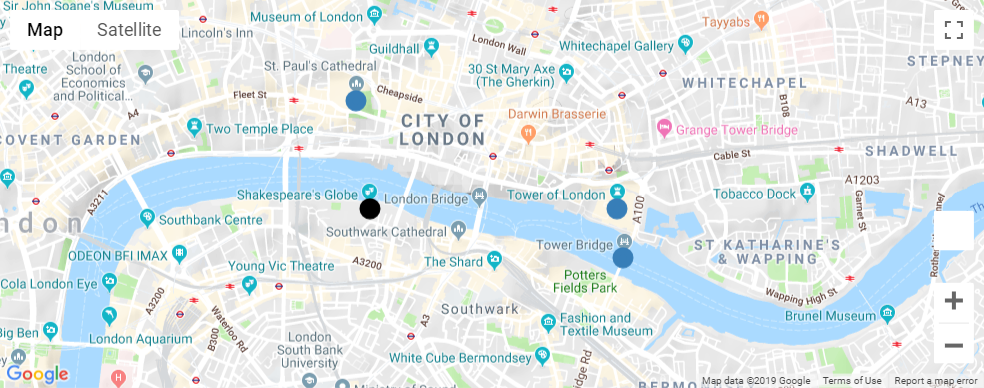

In [43]:
layer = gmaps.symbol_layer(df_subset[['latitude', 'longitude']],
                           fill_color=color_vals, stroke_color=color_vals,
                           scale=7)
fig = gmaps.figure(display_toolbar=True, map_type='TERRAIN')
fig.add_layer(layer)

# fig  # comment out this line if widget cannot display
Image(filename='img/01_london-site-clusters-out-of-sample.png')  # downloaded image

The actual distance between Covent Garden and the British Museum is quite similar to the distance between St Paul's Cathedral and the Globe Theatre.  The British Museum is seen as anomalous by the clustering algorithm though due to cluster 2 (the West End) being much tighter than cluster 0 (City of London and Southwark).

None of the attractions in Chris O's travel guide are in cluster 1 (Kensington & Knightsbridge).  That travel guide is intended to cover essential attractions over a three-day period, so perhaps the museums and shopping activities there do not have a wide appeal, or the area may be seen as too far away from the city centre.

# Summary

**How useful is HDBSCAN for travel planning?:** Clustering with HDBSCAN gives intuition on which notable attractions are grouped close together.  That is useful for identifying areas of interest, but Euclidean distance does not capture 'actual' traversing distance.

**For me it seems that HDBSCAN is highly practical for creating a shortlist of attractions for each day of an itinerary.**  That could reduce the time involved in travel planning as thinking of 'where to start' is often the trickiest thing to do when drafting an itinerary.